In [1]:
from google.cloud import bigquery
from google.oauth2.service_account import Credentials
import pandas as pd

def get_table_metadata(project_id, dataset_id):
    credentials = Credentials.from_service_account_file('secrets/service_account.json')
    # Initialize the BigQuery client
    client = bigquery.Client(credentials=credentials, project=project_id)
    
    # Construct dataset reference
    dataset_ref = client.dataset(dataset_id)

    # List tables in the dataset
    tables = list(client.list_tables(dataset_ref))

    # Collect metadata into a list of dictionaries
    table_metadata = []
    for table in tables:
        table_ref = dataset_ref.table(table.table_id)
        table_info = client.get_table(table_ref)
        
        num_columns = len(table_info.schema)
        num_rows = table_info.num_rows
        
        metadata = {
            'Dataset': dataset_id,
            'Table': table.table_id,
            'Num Columns': num_columns,
            'Num Rows': num_rows
        }
        table_metadata.append(metadata)

    # Convert list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(table_metadata)
    return df


,Dataset,Table,Num Columns,Num Rows
0,bls,c_cpi_u,13,8049
1,bls,cpi_u,13,939014
2,bls,cpsaat18,11,636
3,bls,employment_hours_earnings,7,8164148
4,bls,employment_hours_earnings_series,11,25285
5,bls,unemployment_cps,7,7476103
6,bls,unemployment_cps_series,41,52626
7,bls,wm,7,487054
8,bls,wm_series,16,487054


In [7]:
datasets = []
with open('datasets.txt','r') as f:
    datasets = f.readlines()
datasets = [d.strip() for d in datasets]

In [11]:
from tqdm import tqdm
# Replace 'your_project_id' and 'your_dataset_id' with your actual project and dataset IDs
project_id = 'bigquery-public-data'
res = []

for dataset_id in tqdm(datasets):
    metadata_df = get_table_metadata(project_id, dataset_id)
    res += [metadata_df]
res = pd.concat(res,ignore_index=True)

100%|█████████████████████████████████████████| 315/315 [52:26<00:00,  9.99s/it]


In [14]:
import pickle

with open('table_info.pkl','wb') as f:
    pickle.dump(res,f)

In [17]:
res = res.sort_values('Num Columns')

In [66]:
drops = ['covid','dicom','crypto','patent','chem','idc','proper']

ind1 = res['Dataset'].apply(lambda x: sum([i in x.lower() for i in drops]))
ind2 = res['Table'].apply(lambda x: sum([i in x.lower() for i in drops]))
ind3 = res['Num Columns'] > 10
ind4 = res['Num Rows'] > 10000
rr = res[(ind1==0) & (ind2==0) & ind3 & ind4]
rr

,Dataset,Table,Num Columns,Num Rows
31,bls,employment_hours_earnings_series,11,25285
6803,nhtsa_traffic_fatalities,cevent_2015,11,98431
490,cms_medicare,outpatient_charges_2013,11,44355
489,cms_medicare,outpatient_charges_2012,11,43783
488,cms_medicare,outpatient_charges_2011,11,43372
...,...,...,...,...
8958,wise_all_sky_data_release,all_wise,300,747634026
7794,nppes,npi_raw,330,8218931
8837,usfs_fia,plot_tree,348,22985028
7793,nppes,npi_optimized,480,5943659


In [67]:
rr['Total Size'] = rr['Num Columns'] * rr['Num Rows']
rrg = rr.groupby('Dataset').sum().sort_values('Total Size',ascending=False)


/var/folders/z7/3gg9dn9d10g0krf2rqbxfvrm0000gn/T/ipykernel_79043/4095485642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr['Total Size'] = rr['Num Columns'] * rr['Num Rows']


In [71]:
pd.set_option('display.max_rows', 500)
rrg[rrg['Total Size'] < 1e9].sort_values('Num Columns',ascending=False)

,Table,Num Columns,Num Rows,Total Size
Dataset,,,,
census_bureau_acs,zcta5_2019_5yrblockgroup_2018_5yrblockgroup_20...,13427,3852312,783261453
census_opportunity_atlas,tract_covariatestract_outcomes,7863,147322,576214022
irs_990,irs_990_einirs_990_ez_2012irs_990_2012irs_990_...,2549,5506926,611381466
gdelt_hathitrustbooks,1884188319041881188018981899187918821885189718...,2223,1322737,51586743
ga4_obfuscated_sample_ecommerce,events_20210102events_20201225events_20210112e...,2116,4295584,98798432
gdelt_internetarchivebooks,1911190918951912189419131896189719031907190619...,1692,628366,29533202
nhtsa_traffic_fatalities,cevent_2015cevent_2016vevent_2015vevent_2016 c...,1618,2448853,89918122
noaa_historic_severe_storms,tornado_pathsstorms_1995storms_2009storms_2008...,1141,2197361,71637647
immune_epitope_db,epitope_full_v3receptor_full_v3mhc_ligand_full...,464,7158125,602747892


(array([8.917e+03, 1.100e+01, 2.000e+00, 4.300e+01, 8.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 2.6180e+02, 5.2260e+02, 7.8340e+02, 1.0442e+03,
        1.3050e+03, 1.5658e+03, 1.8266e+03, 2.0874e+03, 2.3482e+03,
        2.6090e+03, 2.8698e+03, 3.1306e+03, 3.3914e+03, 3.6522e+03,
        3.9130e+03, 4.1738e+03, 4.4346e+03, 4.6954e+03, 4.9562e+03,
        5.2170e+03, 5.4778e+03, 5.7386e+03, 5.9994e+03, 6.2602e+03,
        6.5210e+03, 6.7818e+03, 7.0426e+03, 7.3034e+03, 7.5642e+03,
        7.8250e+03]),
 <BarContainer object of 30 artists>)

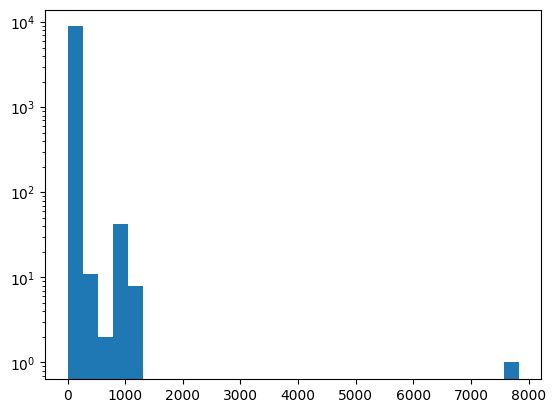

In [32]:
import matplotlib.pyplot as plt

plt.hist(res['Num Columns'],bins=30,log=True)